<a href="https://colab.research.google.com/github/lindermanlab/hackathons/blob/master/structured-vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structured Variational Autoencoders (SVAEs) 
**By Yixiu Zhao and Scott Linderman, Sept 13, 2020**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindermanlab/hackathons/blob/master/structured-vae.ipynb)
___

![SVAE](https://people.csail.mit.edu/mattjj/resources/svae.png)

_Structured_ VAEs [[Johnson et al (2016)](https://papers.nips.cc/paper/6379-composing-graphical-models-with-neural-networks-for-structured-representations-and-fast-inference)] combine probabilistic graphical models (PGMs) and neural networks in a deep generative model. This notebook shows to implement them using [JAX](https://github.com/google/jax/)!

First, here's what you need to know about Structured VAEs.  They rely on two key ideas, a modeling idea and an inference idea.  

### The Modeling Idea
This one is simple enough: replace the standard Gaussian prior on latent variables (aka "codes") with an arbitrary PGM.  Imagine we are modeling a video stream, like bouncing MNIST (a video of handwritten digits bouncing around in a box).  The PGM allows us to express inductive biases; for example, each frame may be described by a low-dimensional latent variable, like the identity and location of each digit, and these latent variables shouldn't change too much from one frame to the next.  The neural network allows us to model the potentially complex mapping from latent variables to observed images; for example, convolutional neural networks are well-suited to this task.  

In a typical setup, we have a joint distribution latent variables $x$ and data $y$ that factors as,
\begin{align}
p(x, y; \theta, \gamma) &= \overbrace{p(x; \theta)}^{\textsf{PGM prior}} \times \underbrace{p(y \mid x; \gamma)}_{\textsf{NN likelihood}}
\end{align}
where $\theta$ parameterize the probabilistic graphical model prior on latent variables, and $\gamma$ parameterize the neural netwok that maps latent variables to a conditional distribution on data.

### The Inference Idea
It's not so hard to stitch together PGMs and neural networks; indeed, over the past four years we've seen dozens of papers that propose something like this. The real question is how to infer the latent variables and estimate the parameters of such a model?  We could use our standard VAE tricks and train a _recogntion network_ that outputs an approximate posterior distribution $q(x; y, \phi)$ on the latent variables, but that wouldn't leverage  our PGM prior.  For example, if our PGM is constructed of conjugate exponential family distributions, we should be able to leverage this structure to perform more efficient posterior inference.  

The second key idea behind the SVAE is that instead of outputting a full posterior distribution on latent variables, the recognition network could instead output a set of _conjugate potentials_ for the PGM.  With these potentials, we can use standard PGM inference algorithms, like coordinate ascent variational inference (CAVI), to obtain the posterior distribution.  This is easier said than done though, so let's break it down.

As usual, we will optimize the evidence lower bound (ELBO) on the marginal likelihood,
\begin{align}
\mathcal{L}(\phi, \theta, \gamma) 
&= \mathbb{E}_{q(x; y, \theta, \phi)} \left[ \log p(x, y; \theta, \gamma) - \log q(x; y, \theta, \phi) \right] \\
&= \log p(y; \theta, \gamma) -\mathrm{KL}\big( q(x; y, \theta, \phi) \,\|\, p(x \mid y; \theta, \gamma) \big) \\
&\leq \log p(y; \theta, \gamma).
\end{align}
Maximizing this objective function wrt $\phi$ is equivalent to minimizing the KL divergence between the approximate posterior and the true posterior; Optimizing wrt $\theta$ and $\gamma$ maximizes the marginal likelihood of the data, integrating over the latent variables.  Importantly, the lower bound holds for any choice of variational posterior $q(x; y, \theta, \phi)$.

The SVAE implicitly defines the variational posterior as the solution to a _surrogate_ variational inference problem,
\begin{align}
q(x; y, \theta, \phi) &= \underset{\mathcal{\tilde{q} \in Q}}{\operatorname{argmin}} \; \mathrm{KL}\big( \tilde{q}(x) \,\|\, \tilde{p}(x; y, \theta, \phi) \big)
\end{align}
where
\begin{align}
\tilde{p}(x; y, \theta, \phi) &\propto 
\overbrace{p(x; \theta)}^{\textsf{PGM prior}} \times \underbrace{\psi(x; y, \phi)}_{\textsf{conjugate potentials}}.
\end{align}
The conjugate potentials are given by the recongition network: it maps data $y$ to functions $\psi(x; y, \phi)$ that are conjugate with the PGM prior.  Since the potentials are conjugate with the PGM prior, solving this surrogate problem is much easier than maximizing the marginal likelihood above.

Notice how similar the surrogate posterior $\tilde{p}(x; y, \theta, \phi)$ is to the joint distribution $p(x, y; \theta, \gamma)$ above.  **Another way to think about the SVAE is that it learns to approximate the neural network likelihood with a conjugate potential for posterior inference.**

<!-- ### The Learning Idea
Ok, we know we said there were only two key ideas, but let us throw in a bonus one just for fun. It turns out that once you've approximated the variaional posterior in this way, you can actually learn the PGM parameters $\theta$ much more efficiently using natural gradient descent, just like in stochastic variational inference [[Hoffman et al (2013)](https://www.jmlr.org/papers/volume14/hoffman13a/hoffman13a.pdf)].  Assume the PGM prior is an exponential family distribution,
\begin{align}
p(x; \theta) &= h(x) \exp \left\{ t(x)^\top \theta - A(\theta) \right \},
\end{align}
where $t(x)$ are the sufficient statistics and $A(\theta)$ is the log normalizer.  Skipping some details and making a few minor assumptions$^*$, the natural gradient updates boil down to accumulating expected sufficient statistics,
\begin{align}
\overline{t(x)} \leftarrow (1-\alpha) \, \overline{t(x)} + \alpha \, \mathbb{E}_{q(x; y, \theta, \phi)}[t(x)]
\end{align}
where $\alpha \in [0,1]$ is a step size, and setting
\begin{align}
\theta &\leftarrow \underset{\theta \in \Theta}{\operatorname{argmax}} \overline{t(x)}^\top \theta - A(\theta) \\
&= [\nabla A]^{-1}\big( \overline{t(x)} \big).
\end{align}
This is just like an exact "M-step" in expectation-maximization, but here we use approximate expected sufficient statistics.

Let's give it a shot!

***
<small>$^*$ Specifically, we are assuming that the minibatches are all the same size and that we have a (potentially improper) uniform prior on the parameters. You might also wonder why the updates for $\theta$ don't have a term involving $\frac{\partial q}{\partial \theta}$; it turns out this term disappears when $q$ is a local optimum of the surrogate variational problem.
</small> -->

# Set up the environment

In [1]:
# We'll use tensorflow probability's nightly build since it includes a JAX substrate
!pip install tfp-nightly

In [2]:
import time
from jax import jit, grad, value_and_grad, lax, vmap
import jax.numpy as np
import jax.random
from jax.nn import softplus
import jax.nn.initializers as nn_init
from jax.experimental import optimizers, stax
from jax.experimental.stax import serial, parallel, Dense, Relu, FanOut, FanInSum, Softplus, Identity
from jax.scipy.special import logsumexp
from jax.tree_util import register_pytree_node

from jax.config import config 
config.update("jax_debug_nans", False)
config.update("jax_enable_x64", False)

import tensorflow_probability as tfp
import tensorflow_probability.substrates.jax.distributions as dists

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

from tqdm.auto import trange

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Register these TFP distributions as PyTrees, if they're not already
try:
    register_pytree_node(
        dists.Normal,
        lambda value: ((value.loc, value.scale), None),
        lambda aux_data, children: dists.Normal(*children)
    )

    register_pytree_node(
        dists.MultivariateNormalFullCovariance,
        lambda value: ((value.loc, value.covariance()), None),
        lambda aux_data, children: dists.MultivariateNormalFullCovariance(*children)
    )

    register_pytree_node(
        dists.Categorical,
        lambda value: ((value.logits_parameter(),), None),
        lambda aux_data, children: dists.Categorical(*children)
    )
except:
    print("Looks like the TFP distributions are already registered.")
    

Looks like the TFP distributions are already registered.


# Let's start with a generic base class for SVAEs

In [63]:
class SVAE(object):

    def prior(self, prior_params):
        """Instantiate a TFP Distribution for the prior using the given params. 
        """
        raise NotImplementedError

    def init_parameters(self, rng, data=None):
        """Initialize parameters for the given dataset. 

        Returns a tuple of (prior_params, recognition_params, decoder_params)
        """
        raise NotImplementedError

    def init_posterior(self, rng, prior_params, recognition_params, data):
        """Optionally, initialize a posterior distribution object for fitting.
        """
        return None

    def recognize(self, recognition_params, data):
        """The recognition network outputs conjugate potentials as TFP Distribution
        objects.
        """
        raise NotImplementedError

    def decode(self, decoder_params, latents):
        """The decoder maps latent variables to a TFP Distribution for the 
        observed data.
        """
        raise NotImplementedError

    def pgm_inference(self, prior_params, potential_params, initial_posterior=None):
        """PGM inference combines the prior and the recognition potentials and
        peforms probabilistic inference to return a posterior distribution.
        """
        raise NotImplementedError

    def pgm_mstep(self, posterior):
        """Solve for the prior parameters that maximize the ELBO using the given
        posterior distribution.  This is typically doable in closed form for 
        conjugate PGMs.
        """
        raise NotImplementedError

    def infer(self, params, data, initial_posterior=None):
        """Given data and parameters, first compute the recognition potentials
        and combine them with the prior in PGM inference.
        """
        # Compute the approximate posterior q(x; y, \theta, \gamma)
        prior_params, recognition_params, decoder_params = params
        prior = self.prior(prior_params)
        potentials = self.recognize(recognition_params, data)
        posterior = self.pgm_inference(prior, potentials, initial_posterior)
        return posterior

    # Define the lower bound on the marginal likelihood to optimize.
    def elbo(self, rng, params, data, 
             initial_posterior=None, 
             num_samples=10,
             kl_scale_factor=1.0):
        """
        Compute a Monte Carlo estimate of the variational lower
        bound.  E_{q(x)}[log p(x,y) - log q(x)].

        rng: a JAX PRNGKey
        
        params: a tuple of prior parameters and variational parameters.
            In future examples, this will also include parameters of the 
            likelihood function in the generative model.

        data: a batch of data

        num_samples: number of samples to draw from the variational posterior.
        """
        prior_params, recognition_params, decoder_params = params
        prior = self.prior(prior_params)
        posterior = self.infer(params, data, initial_posterior)
        
        # Draw samples from the variational posterior
        posterior_samples = posterior.sample(seed=rng, sample_shape=(num_samples,))
        likelihood_per_sample = lambda sample: self.decode(decoder_params, sample).log_prob(data)
        expected_log_likelihood = np.mean(vmap(likelihood_per_sample)(posterior_samples), axis=0)

        # Average over samples from the variational posterior.
        avg_elbo = np.sum(
            expected_log_likelihood - kl_scale_factor * posterior.kl_divergence(prior)) / data.size

        return avg_elbo, posterior

    def fit(self, rng, data, num_iters=100, 
            initial_params=None, initial_posterior=None,
            optimizer=optimizers.adam, optimizer_kwargs=dict(step_size=1e-2)):
        init_prm_rng, init_post_rng, rng = jax.random.split(rng, 3)

        # Initialize the model parameters
        if initial_params is None:
            prior_params, recognition_params, decoder_params = \
                self.init_parameters(init_prm_rng, data)
        else:
            prior_params, recognition_params, decoder_params = initial_params

        # Initialize the first iteration's posterior distribution
        posterior = self.init_posterior(init_post_rng, prior_params, 
                                        recognition_params, data)
        
        # Initialize SGD optimizer for the recognition and decoder parameters
        opt_init, opt_update, get_params = optimizer(**optimizer_kwargs)
        opt_state = opt_init((recognition_params, decoder_params))

        # Define one step of the optimization
        @jit
        def _step(itr, this_rng, opt_state, prior_params, init_posterior):

            # Define a loss wrt the recognition and decoder params only
            def _loss(rec_dec_params):
                params = (prior_params,) + rec_dec_params
                elbo, posterior = self.elbo(this_rng, params, data, init_posterior)
                return -elbo, posterior

            # Take a gradient step wrt the recognition and decoder params
            (negelbo, posterior), g = \
                value_and_grad(_loss, has_aux=True)(get_params(opt_state))
            opt_state = opt_update(itr, g, opt_state)

            # Take a natural gradient step wrt the prior parameters
            prior_params = self.pgm_mstep(posterior)
            return prior_params, opt_state, posterior, -negelbo

        # Run the variational EM algorithm
        elbos = []
        pbar = trange(num_iters)
        for itr in pbar:
            this_rng, rng = jax.random.split(rng, 2)
            prior_params, opt_state, posterior, elbo = \
                _step(itr, this_rng, opt_state, prior_params, posterior)
            elbos.append(elbo)
            pbar.set_description("ELBO: {:.3f}".format(elbo))        

        # Unpack the results
        elbos = np.stack(elbos)
        params = (prior_params,) + get_params(opt_state)
        return elbos, params, posterior

# A Warm-up Example

We'll start with a simple Gaussian-Poisson model,
\begin{align}
x_n &\sim \mathcal{N}(\mu, \sigma) \\
y_n &\sim \mathrm{Po}(f(x_n))
\end{align}
where $x_n \in \mathbb{R}$ is a real-valued latent variable for the $n$-th datapoint, and $y_n \in \mathbb{N}$ is the count-valued observation. The PGM parameters are $\theta = (\mu, \sigma^2)$, the mean and variance of the Gaussian prior. We choose the softplus link function $f(x) = \log (1 + e^x)$; it's a parameter-free one layer neural network!

Since we have a Gaussian prior, the conjugate potentials will also be Gaussian.
The recognition network will output,
\begin{align}
\psi(x_n; y_n, \phi) &= 
\mathcal{N}\big(x_n; \hat{\mu}(y_n, \phi), \hat{\sigma}(y_n, \phi)^2 \big)
\end{align}
where $\hat{\mu}$ and $\hat{\sigma}$ are implemented by a neural network with weights $\phi$.  The first output is a mean and the second is a non-negative scale.

In this case, the _surrogate_ variational inference problem can be solved analytically.  Let $\mathcal{Q} = \big \{\mathcal{N}(\tilde{\mu}, \tilde{\sigma}^2): \tilde{\mu} \in \mathbb{R}, \tilde{\sigma}^2 \in \mathbb{R}_+ \big\}$ denote the class of univariate Gaussian distributions.  Then,
\begin{align}
q(x_n; y_n, \theta, \phi) &= \underset{\mathcal{\tilde{q} \in Q}}{\operatorname{argmin}} \; \mathrm{KL}\big( \tilde{q}(x_n) \,\|\, \tilde{p}(x_n; y_n, \theta, \phi) \big) \\
&\propto p(x_n; \theta) \times \psi(x_n; y_n, \phi) \\
&= \mathcal{N}(x_n; \tilde{\mu}, \tilde{\sigma}^2)
\end{align}
where
\begin{align}
\tilde{\mu} &= \frac{\tilde{h}}{\tilde{J}} &
\tilde{\sigma}^2 &= \frac{1}{\tilde{J}} \\
\tilde{h} &= \frac{\mu}{\sigma^2} + \frac{\hat{\mu}(y_n, \phi)}{\hat{\sigma}(y_n, \phi)^2} &
\tilde{J} &= \frac{1}{\sigma^2} + \frac{1}{\hat{\sigma}(y_n, \phi)^2}
\end{align}
In this example, the SVAE just boils down to a regular old VAE but with a slightly different parameterization of the posterior.  Still, this will serve as a useful building block for more complex SVAEs.

**Note**: We could have parameterized the recognition network to output the _natural_ parameters of the Gaussian potential rather than the _mean_ parameters, as above. Indeed, we started by trying the former! Though both have the same representational capacity, we found that, empirically, it was harder to learn accurate potentials with the natural parameterization than with the mean parameterization.  We use the mean parameters below, and leave a more thorough investigation to the interested reader.

In [5]:
class NormalPoissonSVAE(SVAE):

    def __init__(self, prior_params):
        self.prior_params = prior_params

    # Define the generative model
    def generate(self, rng, prior_params, decoder_params, batch_size):
        rng1, rng2 = jax.random.split(rng, 2)
        latents = dists.Normal(**prior_params).sample(seed=rng1, sample_shape=batch_size)
        # We'd use TFP's Poisson distribution but there seems to be a sample bug right now
        # data = dists.Poisson(softplus(latents)).sample(seed=rng2)
        data = jax.random.poisson(rng2, softplus(latents), shape=(batch_size,))
        return latents, data

    # For comparison, plot the theoretical distribution
    def exact_marginal_likelihood(self, data, prior_params):
        xs = np.linspace(-20, 20, 10000)
        dx = xs[1] - xs[0]
        lps = np.column_stack([
            dists.Normal(**prior_params).log_prob(xs) + 
            dists.Poisson(softplus(xs)).log_prob(y)
            for y in data])
        return np.exp(logsumexp(lps + np.log(dx), axis=0))

    def init_parameters(self, rng, data=None):
        # Define the recognition network.
        # We implement the functions as a split output of a 1-layer MLP
        # https://github.com/google/jax/blob/master/jax/experimental/README.md#neural-net-building-with-stax
        init_recognize, _recognize = serial(
            Dense(50), 
            Relu,
            FanOut(2),
            parallel(
                Dense(1),
                serial(Dense(1), Softplus)
                )
            )
        _, recognition_params = init_recognize(rng, input_shape=(-1, 1))
        self._recognize = _recognize
        # We don't have decoder parameters for the simple Gaussian Poisson model
        decoder_params = None
        return self.prior_params, recognition_params, decoder_params

    def prior(self, prior_params):
        return dists.Normal(**prior_params)

    def decode(self, decoder_params, latents):
        return dists.Poisson(rate=softplus(latents))

    # Stax networks have to take in and output at least 1 dimensional arrays. 
    # We wrap the recognize function to remove this trailing dimension.
    def recognize(self, recognition_params, data):
        loc, scale = self._recognize(recognition_params, data.reshape(-1, 1))
        return dists.Normal(loc=loc[..., 0], scale=scale[...,0])

    # Define the "posterior inference" function to compute the 
    # posterior on x given the prior and the learned potentials.
    def pgm_inference(self, prior, potential, initial_posterior=None):
        """
        Given prior parameters (\mu, \sigma^2) and potentials
        (\eta_1 and \eta_2), compute the posterior parameters
        (\tilde{\mu} and \tilde{\sigma^2}).

        This function is written to operate on a single datapoint's potentials.
        """
        mu_prior, sigma_prior = prior.loc, prior.scale
        mu_lkhd, sigma_lkhd = potential.loc, potential.scale
        h_post = mu_prior / sigma_prior**2 + mu_lkhd / sigma_lkhd**2
        J_post = 1 / sigma_prior**2 + 1 / sigma_lkhd**2
        sigmasq_post = 1 / J_post
        mu_post = h_post / J_post
        return dists.Normal(loc=mu_post, scale=np.sqrt(sigmasq_post))

    def pgm_mstep(self, posterior):
        # In this example we are keeping the prior fixed
        return self.prior_params

## Sample some data from the prior

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


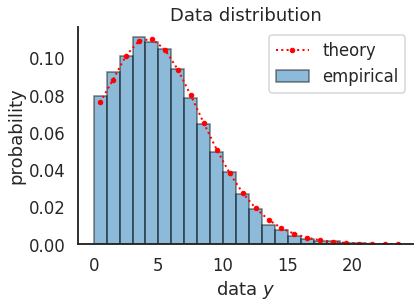

In [6]:
rng = jax.random.PRNGKey(0)
prior_params = dict(loc=5.0, scale=3.0)
decoder_params = None
svae = NormalPoissonSVAE(prior_params)
latents, data = svae.generate(rng, prior_params, decoder_params, batch_size=10000)

# Plot a histogram of the data
ys = np.arange(data.max() + 1)
plt.hist(data, bins=ys, alpha=0.5, edgecolor='k', density=True, label="empirical")
plt.plot(ys + 0.5, svae.exact_marginal_likelihood(ys, prior_params), ':.r', lw=2, label="theory")
plt.xlabel("data $y$")
plt.ylabel("probability")
plt.legend(loc="upper right")
plt.title("Data distribution")
sns.despine()

## Fit the SVAE to the simulated data
For now, we'll hold the prior parameters fixed and just focus on learning the paramters of the recognition network.

In [9]:
elbos, (prior_params, recognition_params, decoder_params), posterior = \
    svae.fit(rng, data, num_iters=200)

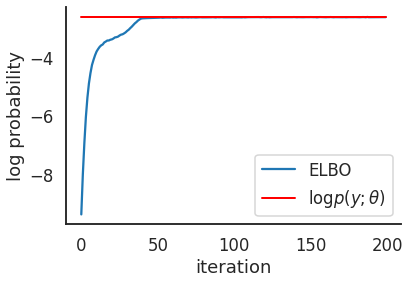

In [10]:
# Plot the ELBOs and, for comparison, the true marginal likelihood of the data
plt.plot(elbos, label="ELBO")
marginal_lkhd = np.mean(np.log(svae.exact_marginal_likelihood(np.arange(data.max()+1), prior_params))[data])
plt.plot(marginal_lkhd * np.ones(len(elbos)), '-r', lw=2, label="$\\log p(y; \\theta)$")
plt.xlabel("iteration")
plt.ylabel("log probability")
plt.legend(loc="lower right")
sns.despine()

Note that there's still a gap between the ELBO and the true marginal likelihood.  This is the **approximation gap**. It can never go to zero because the approximate posterior is constrained to be a Gaussian, while the true posterior is proportional to a Gaussian prior times a Poisson likelihood. 

## Now let's look at the learned potentials

Recall that each potential is an exponentiated quadratic function.  Let's compare these to the Poisson likelihood functions.  Remember that the vertical scale doesn't matter for posterior inference&mdash;those are absorbed by the normalizing constant in the posterior.

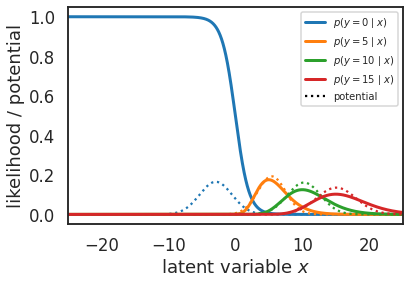

In [11]:
# Compute the approximate potentials given various values of y
xs = np.linspace(-25, 25, 10000)
ys_to_plot = np.array([0, 5, 10, 15])
for y in ys_to_plot:
    # First plot the (normalized) likelihood
    lkhd = svae.decode(decoder_params, xs).prob(y)
    h = plt.plot(xs, lkhd, '-', lw=3, label="$p(y={} \mid x)$".format(y))[0]

    # Then plot the learned potential
    psi = svae.recognize(recognition_params, y).prob(xs)
    plt.plot(xs, psi, ':', color=h.get_color())

# Plot sum dummy lines for the potentials
plt.plot([0], [0], ':k', label="potential")

plt.xlim(-25, 25)
plt.xlabel("latent variable $x$")
plt.ylabel("likelihood / potential")
plt.legend(fontsize=10, loc="upper right")

For the most part, the potentials do a pretty good job of approximating the likelihood.  They can't do a perfect job since the likelihoods aren't Gaussian! (That's the approximation gap we were talking about.) In some cases, like the blue curve showing the likelihood for $y=0$, the approximation is way off &mdash; you simply can't approximate that function with a Gaussian potential very well. Keep that in mind for the example below!

# A more interesting example: Gaussian state space models with Poisson observations

Now let's extend the example above to a sequence of Gaussian latent variables, each with Poisson observations.  We use these models all the time in neuroscience as models of neural spike trains, for example.

Let 
$\mathbf{y}_n = (y_{n,1}, \ldots, y_{n,T}) \in \mathbb{N}^T$ denote the $n$-th datapoint.  It is a length-$T$ vector of counts.  Likewise, let $\mathbf{x}_n = (x_{n,1}, \ldots, x_{n,T}) \in \mathbb{R}^T$ denote a corresponding vector of latent variables associated with this datapoint.  The generative model is,
\begin{align}
\mathbf{x}_n &\sim \mathcal{N}(\mu, \Sigma) \\
y_{n,t} &\sim \mathrm{Po}\big(f(x_{n,t}) \big) \quad \text{ for } t=1,\ldots, T
\end{align}
where $\Sigma$ defines the covariance of the length-$T$ vector of latent variables.

As above, we will use a recognition network to approximate the Poisson likelihood with a learned Gaussian potential.  Moreover, we will share the parameters of the recognition network across all $T$ observations, reflecting the fact that the likelihood is the same for all time-steps.  Then the approximate posterior distribution is,
\begin{align}
q(\mathbf{x}_n; \mathbf{y}_n, \phi) 
&\propto \mathcal{N}(\mathbf{x}_n; \mu, \Sigma) \prod_{t=1}^T \mathcal{N}\big(x_{n,t}; \hat{\mu}(y_{n,t}, \phi), \hat{\sigma}(y_{n,t}, \phi)^2 \big)
\end{align}
where $\hat{\mu}$ and $\hat{\sigma}$ are again neural networks with weights $\phi$.

The approximate posterior distribution can still be computed in closed form,
\begin{align}
q(x; y_n, \theta, \phi) &= \mathcal{N}(\tilde{\mu}, \tilde{\Sigma}) \\
\tilde{h} &= \Sigma^{-1} \mu + \sum_{t=1}^T \frac{\hat{\mu}(y_{n,t}, \phi)}{\hat{\sigma}(y_{n,t}, \phi)^2} \cdot 1_t &
\tilde{J} &= \Sigma^{-1} + \sum_{t=1}^T \frac{1}{\hat{\sigma}(y_{n,t}, \phi)^2} \cdot 1_t 1_t^\top \\
\tilde{\mu} &= \tilde{J}^{-1} \tilde{h} &
\tilde{\Sigma} &= \tilde{J}^{-1}
\end{align}
where $1_t$ is a one-hot length $T$ vector with a 1 in the $t$-th position.

In [12]:
class MultivariateNormalPoissonSVAE(SVAE):

    def __init__(self, prior_params):
        self.prior_params = prior_params

    # Define the generative model
    def generate(self, rng, prior_params, decoder_params, batch_size):
        rng1, rng2 = jax.random.split(rng, 2)
        latents = dists.MultivariateNormalFullCovariance(**prior_params)\
            .sample(seed=rng1, sample_shape=batch_size)
        # We'd use TFP's Poisson distribution but there seems to be a sample bug right now
        # data = dists.Poisson(softplus(latents)).sample(seed=rng2)
        data = jax.random.poisson(rng2, softplus(latents), 
                                shape=(batch_size, prior_params["loc"].size))
        return latents, data

    def init_parameters(self, rng, data=None):
        # We'll use the same recognition network structure as above.
        # It takes in a batch of counts and outputs a mean and covariance
        # for the potential associated with each count.
        init_recognize, _recognize = serial(
            Dense(50), 
            Relu,
            FanOut(2),
            parallel(
                Dense(1),
                serial(Dense(1), Softplus)
                )
            )
        _, recognition_params = init_recognize(rng, input_shape=(-1, 1))
        self._recognize = _recognize

        # We don't have decoder parameters for this simple model
        decoder_params = None
        return self.prior_params, recognition_params, decoder_params

    def recognize(self, recognition_params, data):
        shp = data.shape
        loc, scale = self._recognize(recognition_params, data.reshape(-1, 1))
        return dists.Normal(loc.reshape(shp), scale.reshape(shp))

    def prior(self, prior_params):
        return dists.MultivariateNormalFullCovariance(**prior_params)

    def decode(self, decoder_params, latents):
        return dists.Independent(dists.Poisson(rate=softplus(latents)),
                                 reinterpreted_batch_ndims=1)

    # Define the "posterior inference" function to compute the 
    # posterior on x given the prior and the learned potentials.
    def pgm_inference(self, prior, potential, initial_posterior=None):
        """
        Given prior parameters (\mu, \sigma^2) and potentials
        (\eta_1 and \eta_2), compute the posterior parameters
        (\tilde{\mu} and \tilde{\sigma^2}).

        This function is written to operate on a single datapoint's potentials.
        """
        batch_size, dim = potential.loc.shape
        # TODO: This could probably be a lot faster with Cholesky factors
        mu_prior, Sigma_prior = prior.loc, prior.covariance()
        J_prior = np.linalg.inv(Sigma_prior)
        mu_lkhd, sigma_lkhd = potential.loc, potential.scale
        h_post = J_prior @ mu_prior + mu_lkhd / sigma_lkhd**2
        J_post = vmap(lambda d: J_prior + np.diag(d))(1 / sigma_lkhd**2)
        Sigma_post = np.linalg.inv(J_post)
        mu_post = np.einsum('nij,nj->ni', Sigma_post, h_post)
        return dists.MultivariateNormalFullCovariance(mu_post, Sigma_post)

    def pgm_mstep(self, posterior):
        # In this example we are keeping the prior fixed
        return self.prior_params

Notice that when the latents go below zero, the Poisson rate goes to effectively zero and thus the observed counts do as well.

## Sample some data from the prior

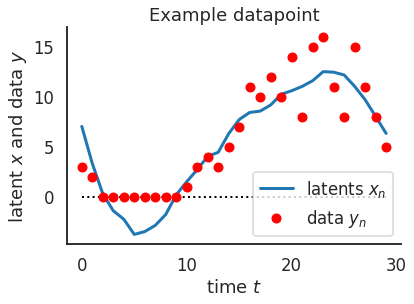

In [13]:
rng = jax.random.PRNGKey(0)
data_dim = 30
kernel = lambda t1, t2: 20 * np.exp(-0.5 * (t1 - t2)**2 / 4**2)
ts = np.arange(data_dim)
prior_params = dict(
    loc=5 * np.ones(data_dim), 
    covariance_matrix=kernel(ts[:, None], ts[None, :]) + 1e-1 * np.eye(data_dim))
decoder_params = None
svae = MultivariateNormalPoissonSVAE(prior_params)
latents, data = svae.generate(rng, prior_params, decoder_params, batch_size=1000)

# Plot one datapoint (i.e. time series)
ind = 1
plt.plot(np.zeros(data_dim), ':k', lw=2)
plt.plot(latents[ind], '-', lw=3, label="latents $x_n$")
plt.plot(data[ind], 'ro', label="data $y_n$")
plt.xlabel("time $t$")
plt.ylabel("latent $x$ and data $y$")
plt.legend(loc="lower right")
plt.title("Example datapoint")
sns.despine()

### Maximize the ELBO with SGD

In [14]:
elbos, (prior_params, recognition_params, decoder_params), posterior = \
    svae.fit(rng, data, num_iters=200)

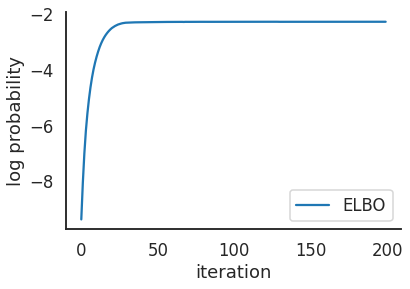

In [15]:
# Plot the ELBOs.  Here, we don't have the luxury of knowing the true marginal
# likelihood, unfortunately.
plt.plot(elbos, label="ELBO")
plt.xlabel("iteration")
plt.ylabel("log probability")
plt.legend(loc="lower right")
sns.despine()

### Look at the inferred posterior distribution

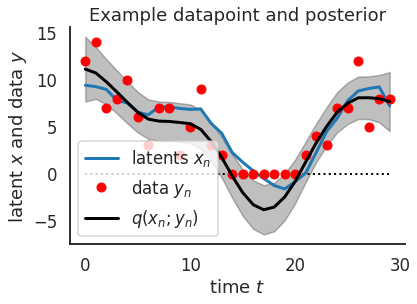

In [28]:
# Compute the approximate potentials 
posteriors = svae.infer((prior_params, recognition_params, decoder_params), data)

# Plot one datapoint (i.e. time series) and its posterior
ind = 2
plt.plot(np.zeros(data_dim), ':k', lw=2)
plt.plot(latents[ind], '-', lw=3, label="latents $x_n$")
plt.plot(data[ind], 'ro', label="data $y_n$")

mu_post, Sigma_post = posteriors.loc[ind], posteriors.covariance()[ind]
h = plt.fill_between(np.arange(data_dim),
                 mu_post - 2 * np.sqrt(np.diag(Sigma_post)),
                 mu_post + 2 * np.sqrt(np.diag(Sigma_post)),
                 alpha=0.25, color='k')
plt.plot(mu_post, color='k', lw=3, label="$q(x_n; y_n)$")

plt.xlabel("time $t$")
plt.ylabel("latent $x$ and data $y$")
plt.legend(loc="lower left")
plt.title("Example datapoint and posterior")
sns.despine()

Note how the inferred latents are underestimating the posterior uncertainty when $x < 0$.  This is the approximation gap in action! Recall the blue curves from above? The learned potential cannot mimic the true likelihood function, which does not fall off for negative $x$ when $y = 0$.  The effect is that the SVAE is overly confident about the posterior when the counts are zero.  It reports a reasonable mean, but the variance is way too small.  We're working on ways to address this approximation gap.

# Final Example: A Gaussian Mixture with Neural Network Observations

Consider the following "pinwheel" dataset.  


### Generate a Pinwheel Dataset

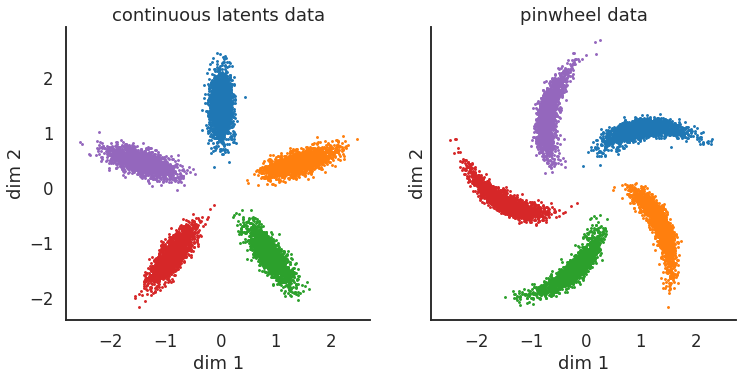

In [29]:
# Fix hyperparameters
data_dim = 2

def sample_pinwheel(rng, num_samples, num_clusters=5, twist_rate=0.5, 
                    distance=1.5, length=0.1, width=0.01):    
    # Initialize the untwisted clusters
    angles = np.linspace(0, 2 * np.pi, num_clusters, endpoint=False)
    perp_dirs = np.zeros((num_clusters, 2))
    locs = np.column_stack((np.sin(angles), np.cos(angles)))
    perp_dirs = np.column_stack((np.cos(angles), -np.sin(angles)))

    covs = np.einsum("ij,ik->ijk", locs, locs) * length \
        + np.einsum("ij,ik->ijk", perp_dirs, perp_dirs) * width
    locs *= distance

    # Sample the data
    def sample_one(key):
        key1, key2 = jax.random.split(key, 2)
        label = jax.random.choice(key1, num_clusters)
        mean = np.take(locs, label, axis=0)
        cov = np.take(covs, label, axis=0)
        latent = dists.MultivariateNormalFullCovariance(mean, cov).sample(seed=key2)

        # Twist the data
        length = np.linalg.norm(latent)
        angle = length * twist_rate
        rot_matrix = np.array([[np.cos(angle), np.sin(angle)],
                               [-np.sin(angle), np.cos(angle)]])
        datapoint = rot_matrix @ latent

        return label, latent, datapoint

    return lax.map(sample_one, jax.random.split(rng, num_samples))

batch_size = 10000
num_clusters = 5
labels, latents, data = sample_pinwheel(jax.random.PRNGKey(0), batch_size, num_clusters)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 8))
for k in range(num_clusters):
    axs[0].scatter(latents[labels == k, 0], latents[labels == k, 1], s=2)
    axs[1].scatter(data[labels == k, 0], data[labels == k, 1], s=2)

axs[0].set_title("continuous latents data")
axs[1].set_title("pinwheel data")

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")
    sns.despine()

### SVAE Formulation

We'll model this with an SVAE in which the PGM prior is a Gaussian mixture model, and the neural network serves to warp the Gaussian components into pinwheels.

**Generative Model:**
Let $z_n \in \{1, \ldots, K\}$ denote discrete class of data point $n$, and $x_n \in \mathbb{R}^2$ a corresponding 2D continuous latent variable.  Finally, let $y_n \in \mathbb{R}^2$ denote the observed datapoint.  We assume the following generative model:
\begin{align}
z_n &\sim \mathrm{Cat}(\pi) \\
x_n &\sim \mathcal{N}(\mu_{z_n}, \Sigma_{z_n}) \\
y_n &\sim \mathcal{N}\big(f(x_n; \gamma), \, \sigma^2 I\big),
\end{align}
where $f: \mathbb{R}^2 \to \mathbb{R}^2$ is the learned warping function, and it is implemented by a neural network with weights $\gamma$.  The PGM prior parameters consist of $\theta = \big(\pi, \{\mu_k, \Sigma_k\}_{k=1}^K\big)$.

**Approximate Posterior:**
Now the SVAE inference step is a bit more interesting.  Recall that the posterior is implicitly defined as the minimizer of the surrogate KL,
\begin{align}
q(x_n, z_n; y_n, \phi) &= \underset{\mathcal{\tilde{q} \in Q}}{\operatorname{argmin}} \; \mathrm{KL}\big( \tilde{q}(z_n, x_n) \,\|\, \tilde{p}(z_n, x_n; y_n, \theta, \phi) \big)
\end{align}
where
\begin{align}
\tilde{p}(z_n, x_n; y_n, \theta, \phi) &\propto \overbrace{\mathrm{Cat}(z_n; \pi) \times \mathcal{N}(x_n; \mu_{z_n}, \Sigma_{z_n})}^{\textsf{PGM prior}} \times \underbrace{\psi(x_n; y_n, \phi)}_{\textsf{conjugate potential}}.
\end{align}
Since the prior is conditionally Gaussian in $x_n$, we choose the conjugate potential to be Gaussian as well.
\begin{align}
\psi(x_n; y_n, \phi) &= \mathcal{N}(x_n; \hat{\mu}(y_n, \phi), \hat{\sigma}^2 I)
\end{align}
For simplicity, we fix its covariance to $\hat{\sigma}^2 I$, though this could easily be output by the network too.

Finally, we choose $\mathcal{Q}$ to be the mean field family, 
\begin{align}
\mathcal{Q} &= \left \{ \mathrm{Cat}(z; \tilde{\pi}) \times \mathcal{N}(x; \tilde{\mu}, \tilde{\Sigma}) : \tilde{\pi} \in \Delta_K, \tilde{\mu} \in \mathbb{R}^2, \tilde{\Sigma} \in \mathbb{R}^2_{\succ 0} \right\}
\end{align}
We solve this surrogate variational inference problem via coordinate ascent.

### Derive the CAVI updates

The mean field coordinate ascent updates are textbook.  See [[Blei et al (2017)](https://www.tandfonline.com/doi/full/10.1080/01621459.2017.1285773)] for details.  Basically, the conditional conjugacy of the PGM prior leads to closed form updates that should converge extremely quickly for this model.  

**Discrete latent variable update**:

The mean field coordinate ascent update for the discrete state is,
\begin{align}
q(z_n; \tilde{\pi}) &\propto 
\exp \left\{\mathbb{E}_{q(x_n; \tilde{\mu}, \tilde{\Sigma})}\left[ \log \mathrm{Cat}(z_n; \pi) + \log \mathcal{N}(x_n; \mu_{z_n}, \Sigma_{z_n} \right] \right \} \\
\implies \tilde{\pi}_k &\propto \exp \left\{\log \pi_k + \mathbb{E}_{q(x_n; \tilde{\mu}, \tilde{\Sigma})}\left[\log \mathcal{N}(x_n \mid \mu_{k}, \Sigma_{k}) \right] \right \} \\
\end{align}
where $\mathbb{E}_{q(x_n; \tilde{\mu}, \tilde{\Sigma})}\left[\log \mathcal{N}(x_n \mid \mu_k, \Sigma_k) \right]$ is the negative cross entropy between the variational posterior and the conditional distribuion.

**Continuous latent variable update**:

The mean field coordinate ascent update for the continuous latent variable is,
\begin{align}
q(x_n; \tilde{\mu}, \tilde{\Sigma})
&\propto \exp \left\{\mathbb{E}_{q(z_n; \tilde{\pi})}\left[\log p(x_n \mid z_n) \right] + \log \psi(x_n; y_n, \phi) \right \} \\
&= \mathcal{N}(x_n; \tilde{\mu}, \tilde{\Sigma}) 
\end{align}
where
\begin{align}
\tilde{\Sigma} &= \tilde{J}^{-1} & \tilde{\mu} &= \tilde{J}^{-1} \tilde{h} \\
\tilde{J} &= \mathbb{E}_{q(z_n; \tilde{\pi})}\left[\Sigma_{z_n}^{-1} \right] + \hat{\sigma}^{-2} I &
\tilde{h} &= \mathbb{E}_{q(z_n; \tilde{\pi})} \left[\Sigma_{z_n}^{-1} \mu_{z_n} \right] + \hat{\sigma}^{-2} \hat{\mu}(y_n, \phi)
\end{align}
and
\begin{align}
\mathbb{E}_{q(z_n; \tilde{\pi})}\left[\Sigma_{z_n}^{-1} \mu_{z_n} \right]
&=
\sum_{k=1}^K \tilde{\pi}_k \Sigma_{k}^{-1} \mu_k
\\
\mathbb{E}_{q(z_n; \tilde{\pi})}\left[\Sigma_{z_n}^{-1} \right]
&=
\sum_{k=1}^K \tilde{\pi}_k \Sigma_{k}^{-1}
\end{align}

CAVI is simply a **fixed-point algorithm** that iteratively applies these two updates until the parameters converge.

### Compute the ELBO given the variational posterior

As above, the ELBO can be written as the expected log likelihood minus the KL to the prior, which simplifies as,
\begin{align}
\mathcal{L} &= \mathbb{E}_{q(z)q(x)} \left[\log p(y \mid x) + \log \frac{p(z)}{q(z)} + \log \frac{p(x \mid z)}{q(x)}\right] \\
&= \mathbb{E}_{q(x)} \left[ \log p(y \mid x) \right] 
-\mathrm{KL}(q(z) \, \| \, p(z)) 
- \mathbb{E}_{q(z)} \left[ \mathrm{KL}(q(x) \, \| \, p(x \mid z)) \right].
\end{align}
Each of these KL divergences is available in closed form.


In [30]:
# Make a simple wrapper for combined Categorical and Multivariate Normal posterior
# TFP has JointDistribution's for this purpose, but it seems a bit tricky to get
# them to work as PyTrees
class CategoricalAndGaussian:
    def __init__(self, q_z, q_x):
        self.q_z, self.q_x = q_z, q_x
    
    def sample(self, seed, sample_shape=(1,)):
        rng1, rng2 = jax.random.split(seed, 2)
        return self.q_z.sample(seed=rng1, sample_shape=sample_shape), \
               self.q_x.sample(seed=rng2, sample_shape=sample_shape)

    def kl_divergence(self, other):
        # Assume "other" is a prior distribution given as a tuple
        # p(z), [p(x | z=1), p(x | z=2, ...)]
        p_z, p_xs = other
        
        # KL[q(z) || p(z)]
        z_kl = self.q_z.kl_divergence(p_z)

        # E_q(z)[KL[q(x) || p(x | z)]]
        x_kls = np.column_stack([self.q_x.kl_divergence(p_x) for p_x in p_xs])
        return z_kl + np.average(x_kls, axis=1, weights=self.q_z.probs_parameter())


register_pytree_node(
    CategoricalAndGaussian,
    lambda value: ((value.q_z, value.q_x), None),
    lambda aux_data, children: CategoricalAndGaussian(*children)
)

In [89]:
class GMMSVAE(SVAE):

    def __init__(self, data_dim, num_clusters):
        self.data_dim = data_dim
        self.num_clusters = num_clusters

    # Define the generative model
    def sample(self, rng, prior_params, decoder_params, sample_shape):
        p_z, p_xs = self.prior(prior_params)
        rng1, rng2, rng3 = jax.random.split(rng, 3)
        
        zs = p_z.sample(sample_shape, rng1)
        means = np.take(np.array([p_x.loc for p_x in p_xs]), zs, axis=0)
        covs = np.take(np.array([p_x.covariance() for p_x in p_xs]), zs, axis=0)
        xs = dists.MultivariateNormalFullCovariance(means, covs).sample(seed=rng2)
        p_y = self.decode(decoder_params, (zs, xs))
        ys = p_y.sample(seed=rng3)
        return zs, xs, ys

    def init_parameters(self, rng, data=None):
        num_clusters, data_dim = self.num_clusters, self.data_dim
        rng_prior, rng_decoder, rng_recongition = jax.random.split(rng, 3)
        
        # Initialize the prior
        rng_means = jax.random.split(rng_prior, num_clusters)
        p_z_params = dict(probs=np.ones(num_clusters) / num_clusters)
        p_x_params = [dict(loc=jax.random.normal(r, shape=(data_dim,)), 
                           covariance_matrix=0.1 * np.eye(data_dim))
                      for r in rng_means]
        prior_params = p_z_params, p_x_params
        
        # Specify the weight initialization
        W_init = nn_init.uniform(0.01)

        # Implement the decoder f: x -> E[y] with a residual network
        init_decode, self._decode = serial(
            FanOut(2),
            parallel(
                serial(
                    Dense(50, W_init=W_init, b_init=W_init),
                    Relu, 
                    Dense(data_dim, W_init=W_init, b_init=W_init)),
                Identity
            ),
            FanInSum
        )
        _, decoder_params = init_decode(rng_decoder, input_shape=(-1, data_dim))
        log_decoder_varaiance = np.log(1e-4)

        # Implement the recongition network with a residual network as well
        init_recognize, self._recognize = serial(
            FanOut(2),
            parallel(
                serial(
                    Dense(50, W_init=W_init, b_init=W_init),
                    Relu, 
                    Dense(data_dim, W_init=W_init, b_init=W_init)
                    ),
                Identity
            ),
            FanInSum
        )
        _, recognition_params = init_recognize(rng_recongition, input_shape=(-1, data_dim))
        log_recognition_variance = np.log(1e-1)

        return prior_params, \
               (recognition_params, log_recognition_variance), \
               decoder_params

    def init_posterior(self, rng, prior_params, recognition_params, data):
        num_data = data.shape[0]
        num_clusters = self.num_clusters
        q_z = dists.Categorical(logits=-np.log(num_clusters) * np.ones((num_data, num_clusters)))
        q_x = self.recognize(recognition_params, data)
        # Broadcast the covariance over the data dimension
        loc, cov = q_x.loc, q_x.covariance()
        cov = cov[None, :, :].repeat(len(data), axis=0)
        q_x = dists.MultivariateNormalFullCovariance(loc, cov)
        return CategoricalAndGaussian(q_z, q_x)

    def prior(self, prior_params):
        # Return the categorical and each mixture component distribution
        categorical_params, mixture_params = prior_params
        return dists.Categorical(**categorical_params), \
               [dists.MultivariateNormalFullCovariance(**prms) for prms in mixture_params]

    def decode(self, decoder_params, latents):
        z, x = latents
        loc = self._decode(decoder_params, x)
        # Hard code the decoder covariance
        covariance = 1e-4 * np.eye(self.data_dim)
        return dists.MultivariateNormalFullCovariance(loc, covariance)

    # Stax networks have to take in and output at least 1 dimensional arrays. 
    # We wrap the recognize function to remove this trailing dimension.
    def recognize(self, recognition_params, data):
        recognition_params, log_recognition_variance = recognition_params
        loc = self._recognize(recognition_params, data)
        cov = np.exp(log_recognition_variance) * np.eye(self.data_dim)
        return dists.MultivariateNormalFullCovariance(loc, cov)

    def pgm_inference(self, prior, potential, initial_posterior=None, max_iter=5):
        p_z, p_xs = prior
        
        def _cavi_discrete(q_x):
            logits = np.log(p_z.probs)
            logits -= np.column_stack([q_x.cross_entropy(p_x) for p_x in p_xs])
            logits -= logsumexp(logits, axis=1, keepdims=True)
            return dists.Categorical(logits=logits)

        def _cavi_continuous(q_z):
            means = np.array([p_x.loc for p_x in p_xs])
            covariances = np.array([p_x.covariance() for p_x in p_xs])

            # First compute expected prior params
            J_prior = np.einsum('nk, kij->nij', q_z.probs_parameter(), np.linalg.inv(covariances))
            h_prior = np.einsum('nk, ki->ni', q_z.probs_parameter(), np.linalg.solve(covariances, means))

            # Then compute effective likelihood
            J_lkhd = np.linalg.inv(potential.covariance())
            # h_lkhd = np.linalg.solve(potential.covariance(), potential.loc)
            h_lkhd = np.einsum('ij,nj->ni', J_lkhd, potential.loc)

            # Combine in posterior
            Sigma_post = np.linalg.inv(J_prior + J_lkhd)
            mu_post = np.einsum('nij, nj->ni', Sigma_post, h_prior + h_lkhd)
            return dists.MultivariateNormalFullCovariance(mu_post, Sigma_post)

        def _cavi_step(posterior, dummy):
            q_z = _cavi_discrete(posterior.q_x)
            q_x = _cavi_continuous(q_z)
            return CategoricalAndGaussian(q_z, q_x), None

        if initial_posterior is None:
            num_data = potential.loc.shape[0]
            num_clusters = self.num_clusters
            q_z = dists.Categorical(logits=-np.log(num_clusters) * np.ones((num_data, num_clusters)))
            loc = potential.loc
            cov = potential.covariance()
            q_x = dists.MultivariateNormalFullCovariance(loc, cov[None, :, :].repeat(len(data), axis=0))
            initial_posterior = CategoricalAndGaussian(q_z, q_x)

        posterior, _ = lax.scan(_cavi_step, initial_posterior, None, length=max_iter)
        return posterior

    def pgm_mstep(self, posterior, kappa0=1e-4, mu0=0, Psi0=1e-4, nu0=1e-4):
        q_z = posterior.q_z
        q_x = posterior.q_x

        # Update the cluster probabilities
        q_z_probs = q_z.probs_parameter()
        p_z = dists.Categorical(probs=q_z_probs.sum(axis=0) / q_z_probs.shape[0])

        # Helper function to compute posterior mode of normal-inverse Wishart dist
        def niw_posterior_mode(n, Ex, ExxT):
            kappa = kappa0 + n
            mu = (mu0 + Ex) / kappa
            Psi = Psi0 * np.eye(data_dim) + ExxT - kappa * np.outer(mu, mu)
            nu = nu0 + n
            return dists.MultivariateNormalFullCovariance(mu, Psi / nu)

        # Update the means and covariances for each cluster
        p_xs = []
        for k in range(self.num_clusters):
            # Compute expected sufficient stats
            weights = q_z_probs[:, k]
            Ex = np.einsum('n,ni->i', weights, q_x.loc)
            ExExT = np.einsum('ni,nj->nij', q_x.loc, q_x.loc)
            ExxT = np.einsum('n,nij->ij', weights, q_x.covariance() + ExExT)
            
            # Compute the NIW posterior mode
            p_xs.append(niw_posterior_mode(weights.sum(), Ex, ExxT))
        
        return dict(probs=p_z.probs), [dict(loc=p_x.loc, covariance_matrix=p_x.covariance()) for p_x in p_xs]


In [76]:
# Create and fit a GMM SVAE
gmm = GMMSVAE(data_dim=2, num_clusters=5)
rng = jax.random.PRNGKey(0)
elbos, params, posterior = gmm.fit(
    rng, data, num_iters=2000, 
    optimizer=optimizers.adam,
    optimizer_kwargs=dict(step_size=1e-2))

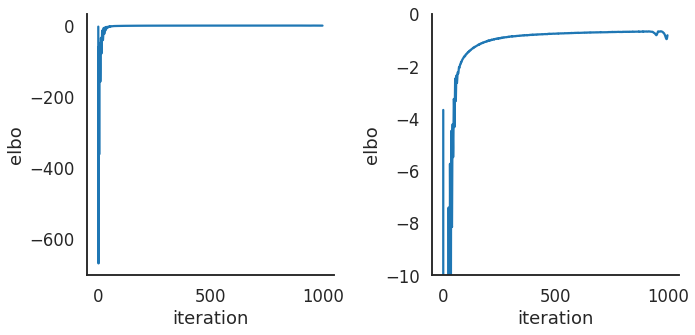

In [91]:
# Plot the ELBOs.
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(elbos)
axs[1].plot(elbos)
axs[1].set_ylim(-10, 0)

for ax in axs:
    ax.set_xlabel("iteration")
    ax.set_ylabel("elbo")
    sns.despine(ax=ax)

plt.tight_layout()

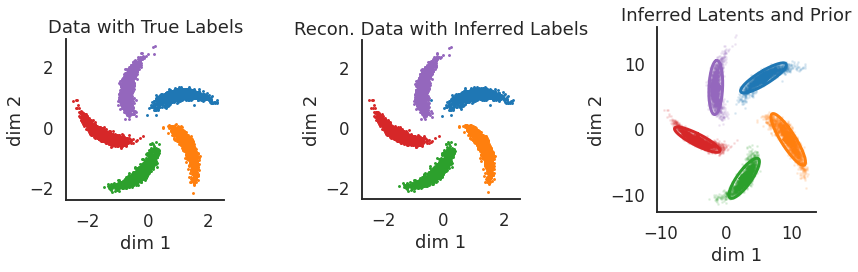

In [98]:
def plot_gaussian_2D(mu, Sigma, ax=None, **kwargs):
    """
    Helper function to plot 2D Gaussian contours
    """
    angles = np.hstack([np.arange(0, 2*np.pi, 0.01), 0])
    circle = np.vstack([np.sin(angles), np.cos(angles)])
    ellipse = np.dot(2 * np.linalg.cholesky(Sigma), circle)

    ax = plt.gca() if ax is None else ax
    point = ax.plot(mu[0], mu[1], marker='D', **kwargs)
    line, = ax.plot(ellipse[0, :] + mu[0], ellipse[1, :] + mu[1], **kwargs)
    
p_z, p_xs = gmm.prior(params[0])
posterior = gmm.infer(params, data)
q_z, q_x = posterior.q_z, posterior.q_x
inferred_labels = np.argmax(q_z.logits, axis=1)

# Reconstruct the data
reconstructed_data = gmm.decode(params[2], (q_z.probs_parameter(), q_x.loc)).loc

# Color the data by their inferred posterior
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
for k in range(labels.max() + 1):
    axs[0].scatter(data[labels == k, 0], 
                   data[labels == k, 1], s=2)

for k in range(inferred_labels.max() + 1):
    h = axs[1].scatter(reconstructed_data[inferred_labels == k, 0], 
                       reconstructed_data[inferred_labels == k, 1], s=2)

for k in range(inferred_labels.max() + 1):
    h = axs[2].scatter(q_x.loc[inferred_labels == k, 0], 
                       q_x.loc[inferred_labels == k, 1], s=2, alpha=0.1)
    plot_gaussian_2D(p_xs[k].loc, p_xs[k].covariance(), ax=axs[2], 
                     color=h.get_facecolor()[0], alpha=1.0, lw=3)

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")
    sns.despine()

axs[0].set_title("Data with True Labels")
axs[1].set_title("Recon. Data with Inferred Labels")
axs[2].set_title("Inferred Latents and Prior")
plt.tight_layout()

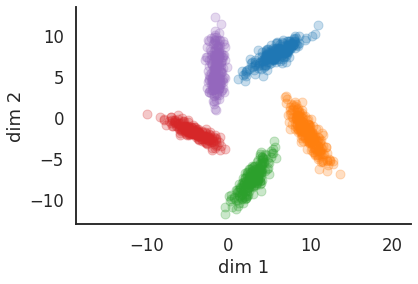

In [93]:
# Sample
z, x, y = gmm.sample(jax.random.PRNGKey(1), params[0], params[2], sample_shape=1000)
for k in range(gmm.num_clusters):
    plt.plot(x[z==k, 0], x[z==k, 1], 'o', alpha=0.25)

plt.axis("equal")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
sns.despine()

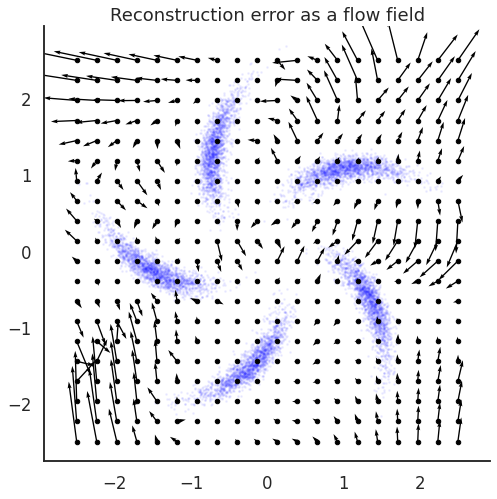

In [107]:
# Look at how the recognition network changes the data
X, Y = np.meshgrid(np.linspace(-2.5, 2.5, 20),
                   np.linspace(-2.5, 2.5, 20))

xy = np.column_stack((X.ravel(), Y.ravel()))
xy_rec = gmm.recognize(params[1], xy).loc
xy_dec = gmm.decode(params[2], (None, xy_rec)).loc
dxy = xy_dec - xy

plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], s=2, color='b', alpha=0.05)
plt.quiver(xy[:,0], xy[:,1], dxy[:,0], dxy[:,1], angles='xy')
plt.plot(xy[:,0], xy[:,1], '.k')
# plt.plot(xy_dec[:,0], xy_dec[:,1], '.r')
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.axis("equal")
plt.title("Reconstruction error as a flow field")
sns.despine()

# Work in progress


### Check capacity of recognition network

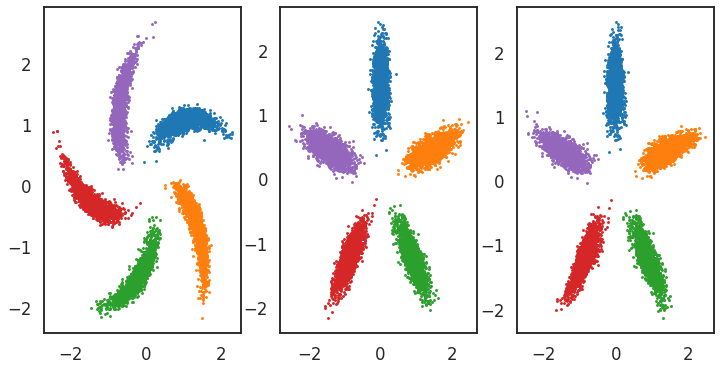

In [106]:
W_init = nn_init.uniform(0.01)
init_recognize, _recognize = \
    serial(
        FanOut(2),
        parallel(
            serial(
                Dense(50, W_init=W_init, b_init=W_init),
                Relu, 
                # Dense(50, W_init=W_init, b_init=W_init),
                # Relu, 
                Dense(data_dim, W_init=W_init, b_init=W_init)
                ),
            Identity
        ),
        FanInSum
    )
_, recognition_params = init_recognize(jax.random.PRNGKey(0), input_shape=(-1, data_dim))


def loss(prms):
    return np.sum((_recognize(prms, data) - latents)**2) / data.size

step_size = 0.0001
momentum_mass = 0.9
# opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)
opt_init, opt_update, get_params = optimizers.adam(1e-2)
opt_state = opt_init(recognition_params)

# Take a gradient step wrt the recognition and decoder params
pbar = trange(1000)
f = jit(value_and_grad(loss))
for itr in pbar:
    val, g = f(get_params(opt_state))
    opt_state = opt_update(itr, g, opt_state)
    pbar.set_description("loss: {:.2f}".format(val))

# Plot the true and inferred latents
inferred_latents = _recognize(get_params(opt_state), data)

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
for k in range(labels.max() + 1):
    axs[0].scatter(data[labels == k, 0], data[labels == k, 1], s=2)
    axs[1].scatter(latents[labels == k, 0], latents[labels == k, 1], s=2)
    axs[2].scatter(inferred_latents[labels == k, 0], inferred_latents[labels == k, 1], s=2)


### Implement a generic fixed point function and its gradient

This is slightly modified from the [JAX tutorial](https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html).

In [ ]:
# Write a helper function to evaluate fixed points
# from 
from functools import partial
from jax.lax import while_loop
from jax import vjp, custom_vjp
from jax.flatten_util import ravel_pytree

@partial(custom_vjp, nondiff_argnums=(0,))
def _fixed_point(f, a, x_guess):
    def cond_fun(carry):
        x_prev, x = carry
        delta = np.abs(x_prev - x).mean()
        return delta > 1e-4

    def body_fun(carry):
        _, x = carry
        return x, f(a, x)

    _, x_star = while_loop(cond_fun, body_fun, (x_guess, f(a, x_guess)))
    return x_star

def _fixed_point_fwd(f, a, x_init):
    x_star = _fixed_point(f, a, x_init)
    return x_star, (a, x_star)

def _fixed_point_rev(f, res, x_star_bar):
    a, x_star = res
    _, vjp_a = vjp(lambda a: f(a, x_star), a)
    a_bar, = vjp_a(_fixed_point(partial(_rev_iter, f),
                                (a, x_star, x_star_bar),
                                x_star_bar))
    return a_bar, np.zeros_like(x_star)

def _rev_iter(f, packed, u):
    # Subtract a small value to stablize the reverse iteration
    a, x_star, x_star_bar = packed
    _, vjp_x = vjp(lambda x: f(a, x), x_star)
    return (x_star_bar + vjp_x(u)[0])

_fixed_point.defvjp(_fixed_point_fwd, _fixed_point_rev)

def fixed_point(f, a, x0):
    """
    Iteratively run the fixed point iteration
    ..math:
        x \from f(a, x)

    with parameters :math:`a`, until the L1 norm of the change in :math:`x` is 
    less than the specified tolerance.

    `f` is a function that maps `a, x -> x`

    `a` are the parameters of the function

    `x0` is an initial guess at the fixed point

    `tolerance` specifies the necessary L1 norm of the change in output before 
    convergence is reached. 
    """
    # Use tree flatten and unflatten to convert inputs from PyTrees to flat arrays
    a_flat, unravel_a = ravel_pytree(a)
    x0_flat, unravel_x = ravel_pytree(x0)
    
    # Wrap the objective function to consume flat _original_ 
    # numpy arrays and produce scalar outputs.
    def f_wrapper(a_flat, x_flat):
        a = unravel_a(a_flat)
        x = unravel_x(x_flat)
        return ravel_pytree(f(a, x))[0]

    return unravel_x(_fixed_point(f_wrapper, a_flat, x0_flat))

# # Test out the fixed point on a square root function
# def newton_sqrt(a):
#     update = lambda a, x: 0.5 * (x + a / x)
#     return _fixed_point(update, a, a)

# def newton_sqrt_dict(args):
#     update = lambda args, x: 0.5 * np.atleast_1d(x + args['a'] / x)
#     return fixed_point(update, args, args['a'])

# print("sqrt(2.0):             ", np.sqrt(2.0))
# print("newton_sqrt(2.0):      ", newton_sqrt(2.0))
# print("newton_sqrt_dict(2.0): ", newton_sqrt_dict(dict(a=2.0)))

# # Test gradients
# print("g1 ", grad(np.sqrt)(2.0))
# print("g2 ", grad(newton_sqrt)(2.0))
# print("g3 ", grad(newton_sqrt_dict)(dict(a=2.0)))